In [1]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from mlxtend.plotting import plot_decision_regions 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

In [2]:
meme_df = pd.read_csv('data/meme_coins.csv')
stable_df = pd.read_csv('data/stable_coins.csv')
defi_df = defi_df = pd.read_csv('data/defi_coins.csv')

In [3]:
meme_df['meme'] = 1
stable_df['stable'] = 1
defi_df['defi'] = 1

In [4]:
def clean_numeric_column(series):
    return series.astype(str).apply(lambda x: re.sub(r'[^\d.-]', '', x))

In [5]:
numeric_columns = ['price', 'market cap', '24h volume', '24h', '7d', '30d']
for df in [meme_df, stable_df, defi_df]:
    for col in numeric_columns:
        if col in df.columns:
            df[col] = clean_numeric_column(df[col])
            df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
df = pd.concat([meme_df, stable_df, defi_df], axis=0)
df = df.fillna(0)
df = df.groupby('symbol').agg({
    'name': 'first',
    'price': 'first', 
    'market cap': 'first',
    '24h volume': 'first',
    '24h': 'first',
    '7d': 'first',
    '30d': 'first',
    'meme': 'max',
    'stable': 'max',
    'defi': 'max'
}).reset_index()

df[['meme', 'stable', 'defi']] = df[['meme', 'stable', 'defi']].astype(int)

In [7]:
df.head(5)

,symbol,name,price,market cap,24h volume,24h,7d,30d,meme,stable,defi
0,1000SATS,SATS,0.000002,51.18,2.26,-1.80,-1.09,-40.90,1,0,0
1,4,4,0.112700,122.79,25.97,-8.02,-5.30,-24.99,1,0,0
2,AAVE,Aave,226.550000,3.46,119.74,-1.70,5.39,-12.96,0,0,1
3,AERO,Aerodrome Finance,0.816000,738.49,18.01,0.15,4.30,-17.08,0,0,1
4,AETHUSDT,Aave Ethereum USDT,1.000000,6.15,31.33,0.01,-0.03,-0.01,0,1,1


In [8]:
df.shape

(143, 11)

In [9]:
df.drop(['name'], axis=1, inplace=True)

In [10]:
df.head()

,symbol,price,market cap,24h volume,24h,7d,30d,meme,stable,defi
0,1000SATS,0.000002,51.18,2.26,-1.80,-1.09,-40.90,1,0,0
1,4,0.112700,122.79,25.97,-8.02,-5.30,-24.99,1,0,0
2,AAVE,226.550000,3.46,119.74,-1.70,5.39,-12.96,0,0,1
3,AERO,0.816000,738.49,18.01,0.15,4.30,-17.08,0,0,1
4,AETHUSDT,1.000000,6.15,31.33,0.01,-0.03,-0.01,0,1,1


In [11]:
df_pca = df.drop(['symbol'], axis=1)
df_pca['24h'] = df_pca['24h'].map(lambda x: abs(float(x)))
df_pca['7d'] = df_pca['7d'].map(lambda x: abs(float(x)))
df_pca['30d'] = df_pca['30d'].map(lambda x: abs(float(x)))

In [12]:
df_pca.head()

,price,market cap,24h volume,24h,7d,30d,meme,stable,defi
0,0.000002,51.18,2.26,1.80,1.09,40.90,1,0,0
1,0.112700,122.79,25.97,8.02,5.30,24.99,1,0,0
2,226.550000,3.46,119.74,1.70,5.39,12.96,0,0,1
3,0.816000,738.49,18.01,0.15,4.30,17.08,0,0,1
4,1.000000,6.15,31.33,0.01,0.03,0.01,0,1,1


In [13]:
standard_scaler = StandardScaler()
df_pca = standard_scaler.fit_transform(df_pca)

In [14]:
pca = PCA()
pca_result = pca.fit_transform(df_pca)

In [15]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['symbol'] = df['symbol'].values

In [16]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,symbol
0,1.741889,-0.913389,-0.915878,-0.184924,-0.704623,-0.176326,-0.165500,0.824518,-0.000575,1000SATS
1,2.783979,-0.660453,0.158941,-0.541705,1.430789,-0.849346,1.836962,0.918733,0.132788,4
2,-0.042605,1.358262,0.291768,-0.358794,0.112493,-1.061707,-0.490822,-0.042653,-0.169401,AAVE
3,-0.017955,1.833559,-0.297193,2.226528,0.134914,0.428512,-0.359532,-0.169660,-0.101244,AERO
4,-1.910537,0.328381,0.003520,-0.095877,0.430330,-0.661187,-0.778662,-0.065357,1.041324,AETHUSDT


In [17]:
pca_df = pd.concat([pca_df, df['meme'], df['stable'], df['defi']], axis = 1)

/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24065 (\N{CJK UNIFIED IDEOGRAPH-5E01}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


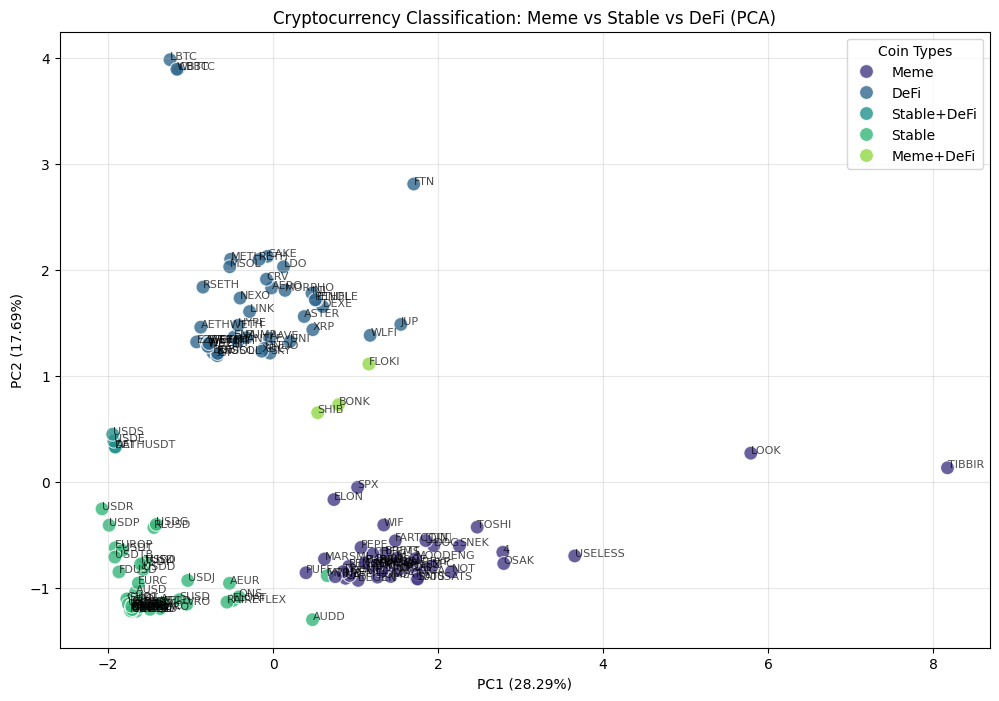

In [18]:
plt.figure(figsize=(12, 8))

def get_class(row):
    if row['meme'] == 1 and row['stable'] == 1 and row['defi'] == 1:
        return 'Meme+Stable+DeFi'
    elif row['meme'] == 1 and row['stable'] == 1:
        return 'Meme+Stable'
    elif row['meme'] == 1 and row['defi'] == 1:
        return 'Meme+DeFi'
    elif row['stable'] == 1 and row['defi'] == 1:
        return 'Stable+DeFi'
    elif row['meme'] == 1:
        return 'Meme'
    elif row['stable'] == 1:
        return 'Stable'
    elif row['defi'] == 1:
        return 'DeFi'
    else:
        return 'Other'

pca_df['Class'] = pca_df.apply(get_class, axis=1)

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in pca_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Cryptocurrency Classification: Meme vs Stable vs DeFi (PCA)')
plt.legend(title='Coin Types')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
X = pca_df[['PC1', 'PC2']]
y = df[['meme', 'stable', 'defi']]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
multi_label_logistic_regression = MultiOutputClassifier(LogisticRegression())
multi_label_logistic_regression.fit(X_train, y_train)

,estimator,LogisticRegression()
,n_jobs,None
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/var/folders/cd/1qdj9rln31b4qg7ltkhk9s080000gq/T/ipykernel_41515/921165189.py:58: UserWarning: Glyph 24065 (\N{CJK UNIFIED IDEOGRAPH-5E01}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cd/1qdj9rln31b4qg7ltkhk9s080000gq/T/ipykernel_41515/921165189.py:58: UserWarning: Glyph 23433 (\N{CJK UNIFIED I

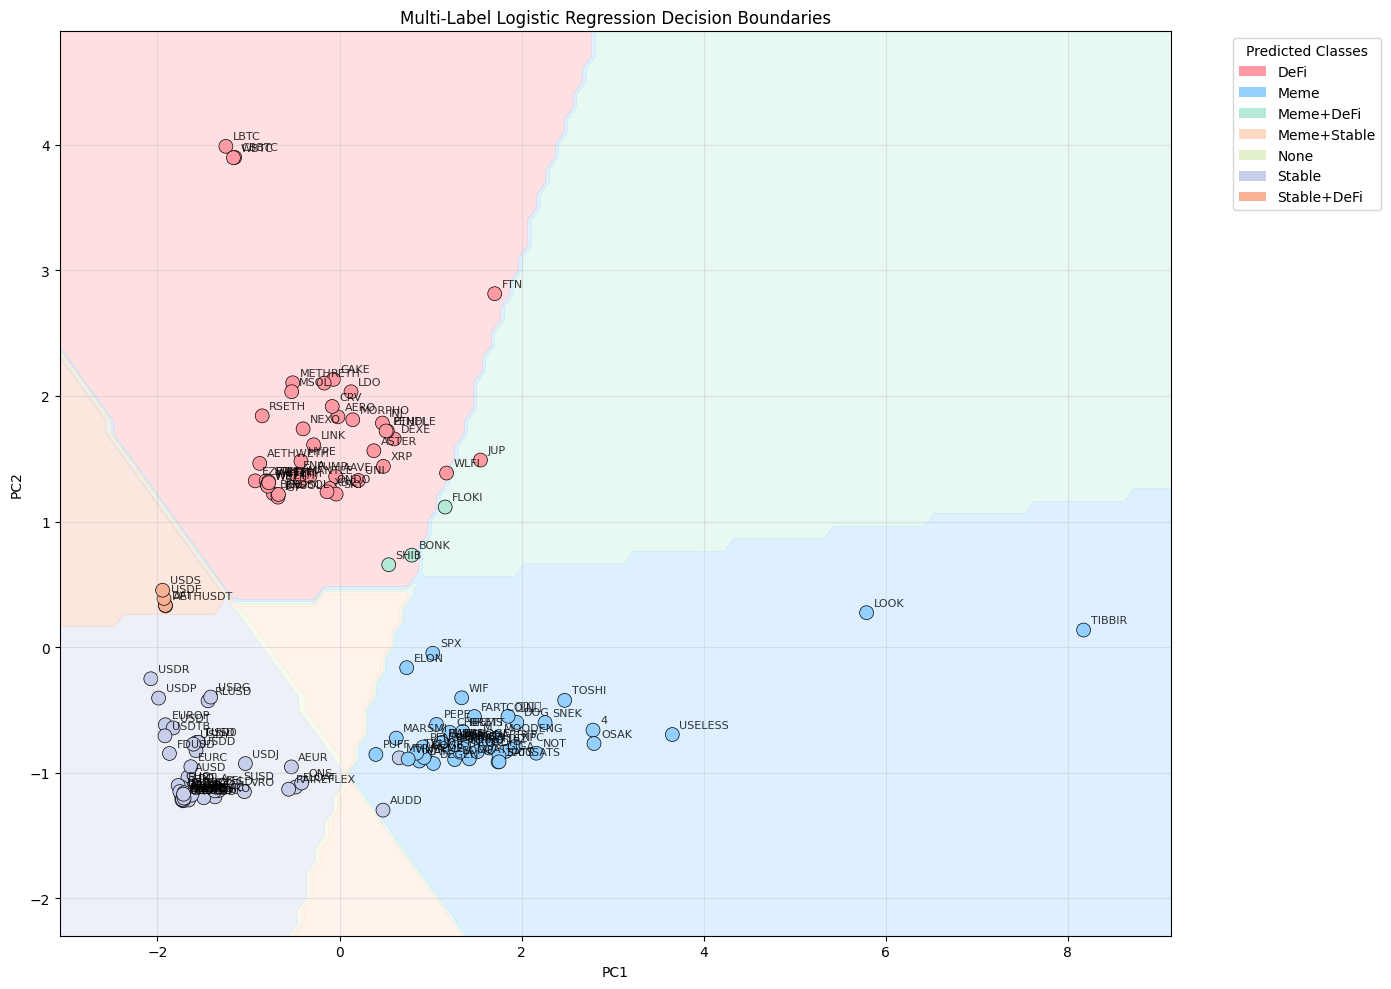

In [22]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_logistic_regression.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

colors = [
    '#FF9AA2',  # Soft coral pink (Meme)
    '#94D0FF',  # Soft sky blue (Stable) 
    '#B5EAD7',  # Soft mint green (DeFi)
    '#FFDAC1',  # Soft peach (Meme+Stable)
    '#E2F0CB',  # Soft lime (Meme+DeFi)
    '#C7CEEA',  # Soft lavender (Stable+DeFi)
    '#F8B195',  # Soft salmon (Meme+Stable+DeFi)
    '#D8D8D8'   # Soft gray (None)
]
cmap = ListedColormap(colors[:len(unique_labels)])

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Logistic Regression Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
multi_label_knn = MultiOutputClassifier(KNeighborsClassifier())
multi_label_knn.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,n_jobs,None
,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


KeyError: 'Stable+DeFi'

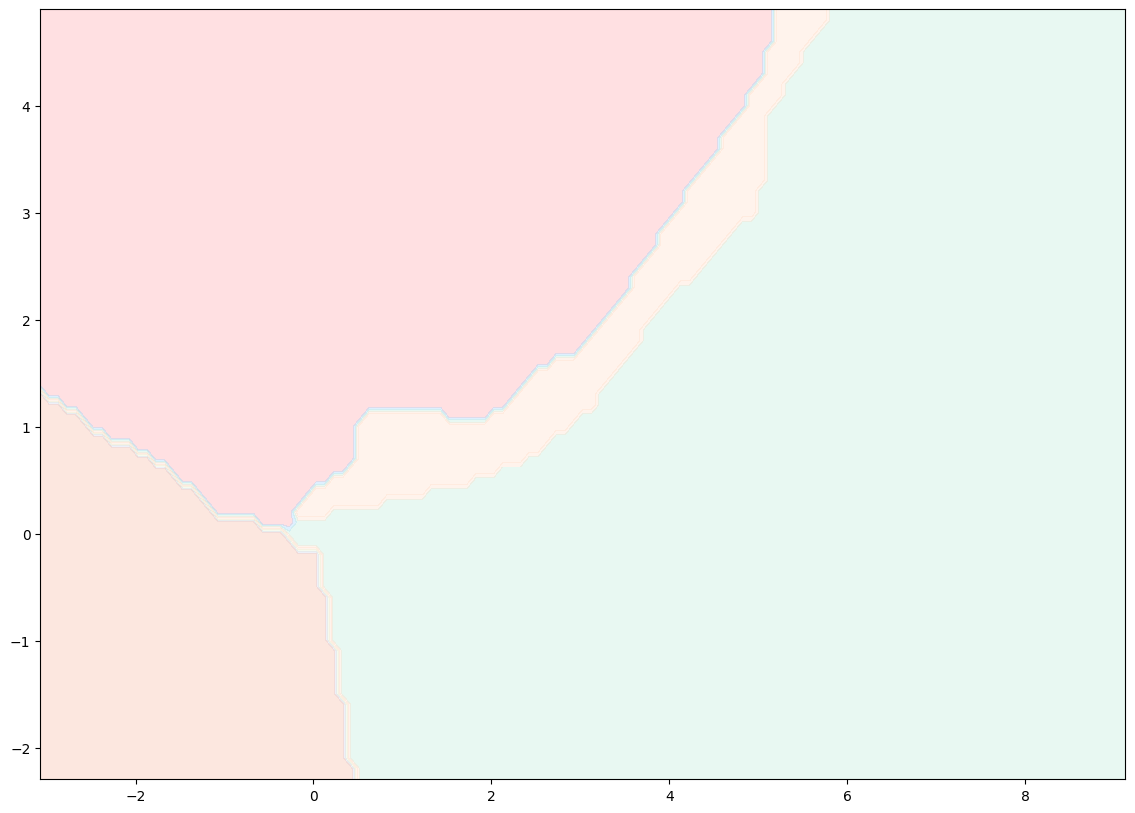

In [24]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_knn.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label KNN Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
multi_label_nearest_centroid = MultiOutputClassifier(NearestCentroid())
multi_label_nearest_centroid.fit(X_train, y_train)

,estimator,NearestCentroid()
,n_jobs,None
,metric,'euclidean'
,shrink_threshold,None
,priors,'uniform'


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestCentroid was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestCentroid was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestCentroid was fitted with feature names
  warnings.warn(


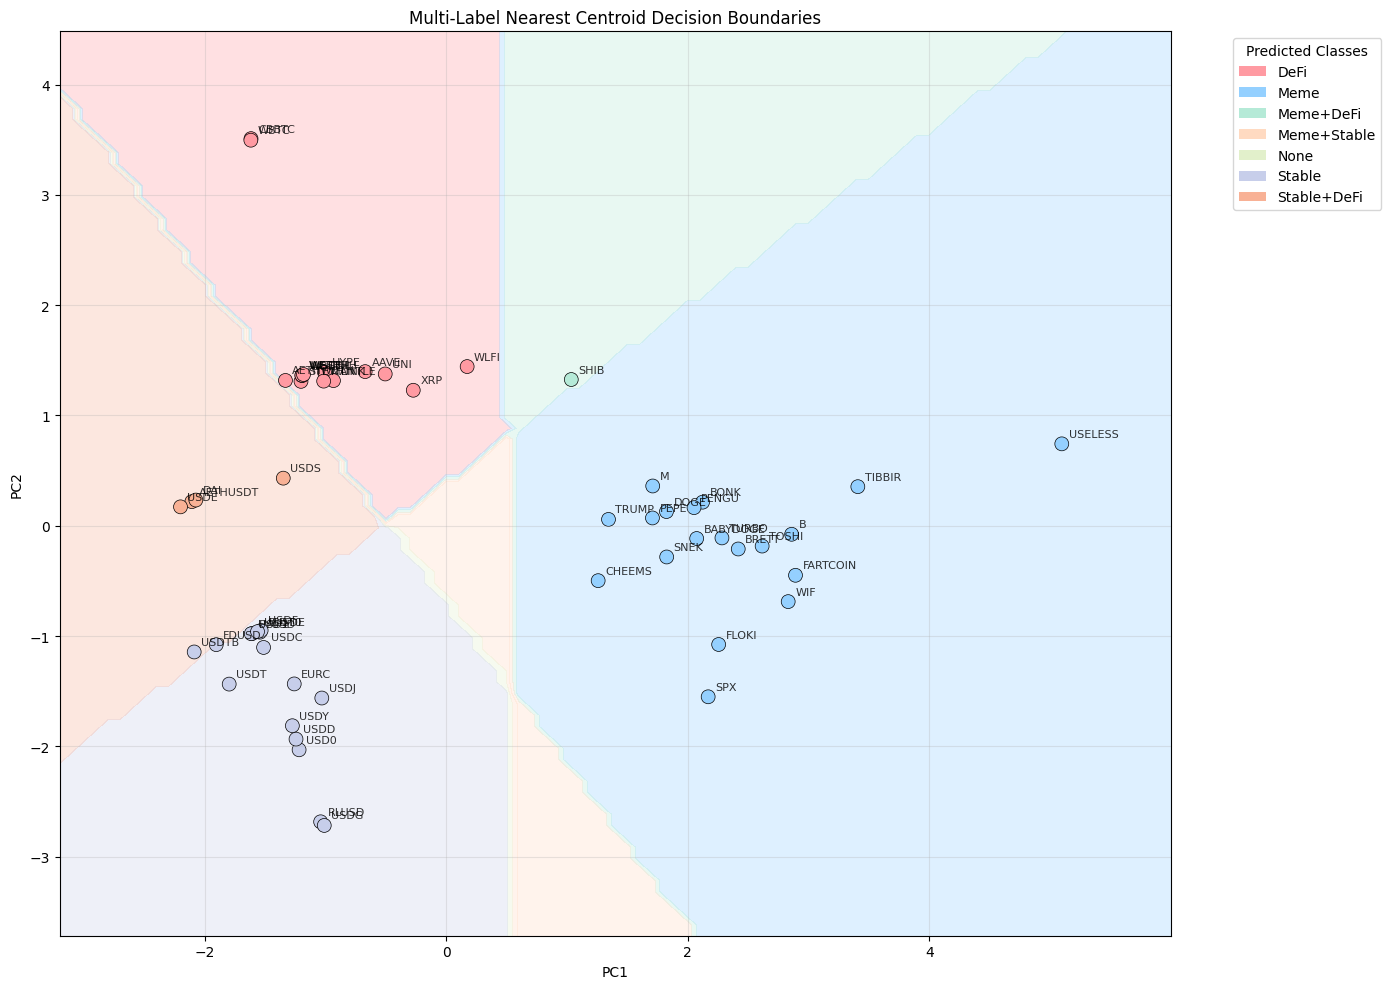

In [ ]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_nearest_centroid.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Nearest Centroid Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
multi_label_svc_linear = MultiOutputClassifier(SVC(kernel='linear'))
multi_label_svc_linear.fit(X_train, y_train)

,estimator,SVC(kernel='linear')
,n_jobs,None
,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


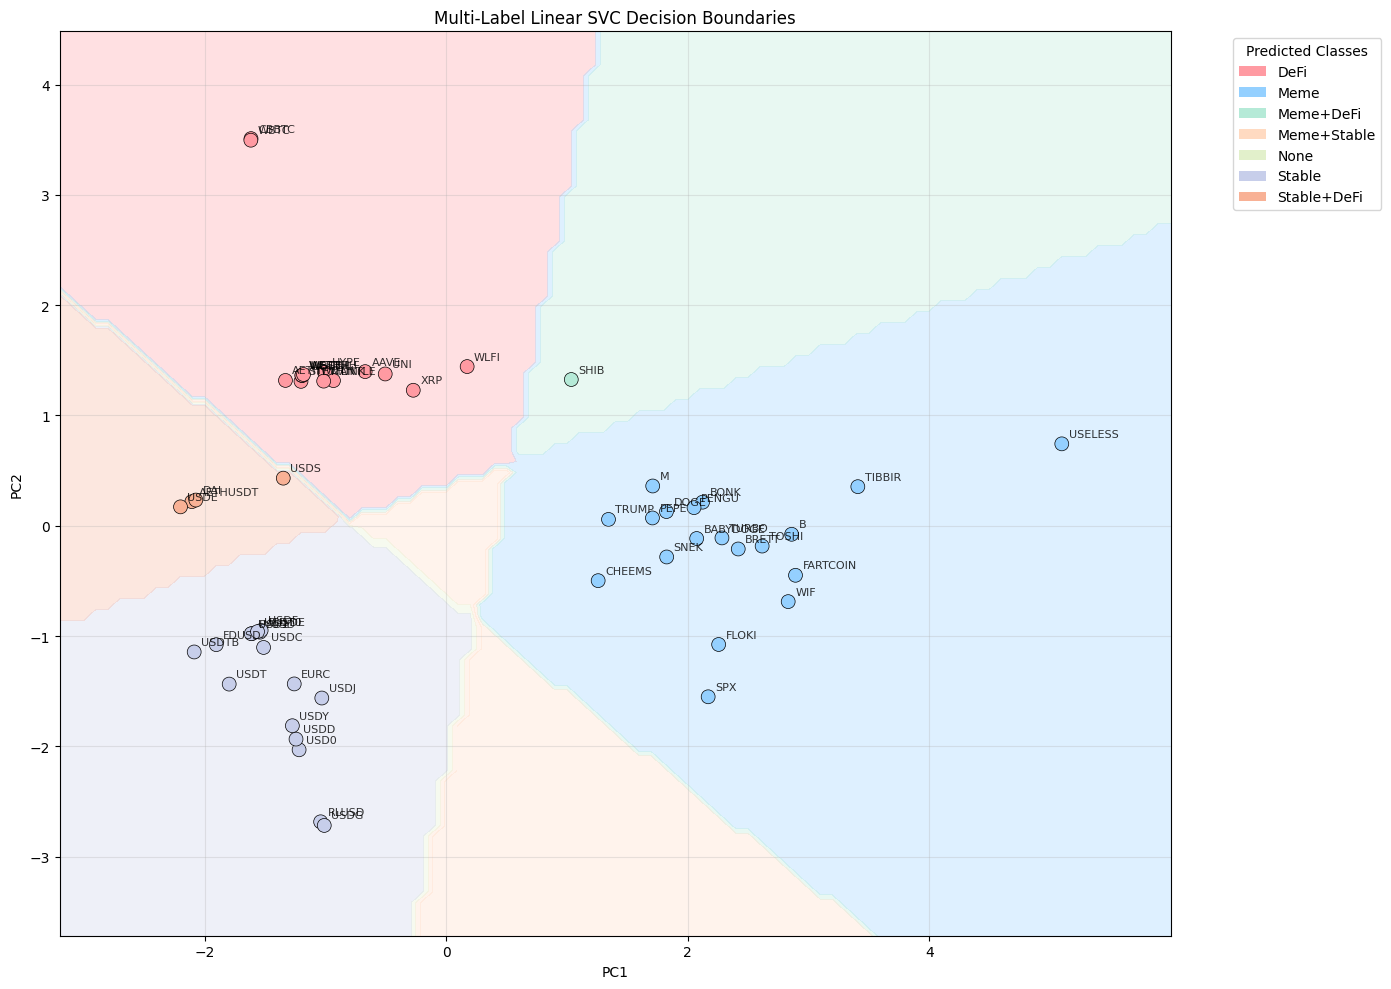

In [ ]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_svc_linear.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Linear SVC Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
multi_label_svc_poly = MultiOutputClassifier(SVC(C=10, kernel='poly'))
multi_label_svc_poly.fit(X_train, y_train)

,estimator,"SVC(C=10, kernel='poly')"
,n_jobs,None
,C,10
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


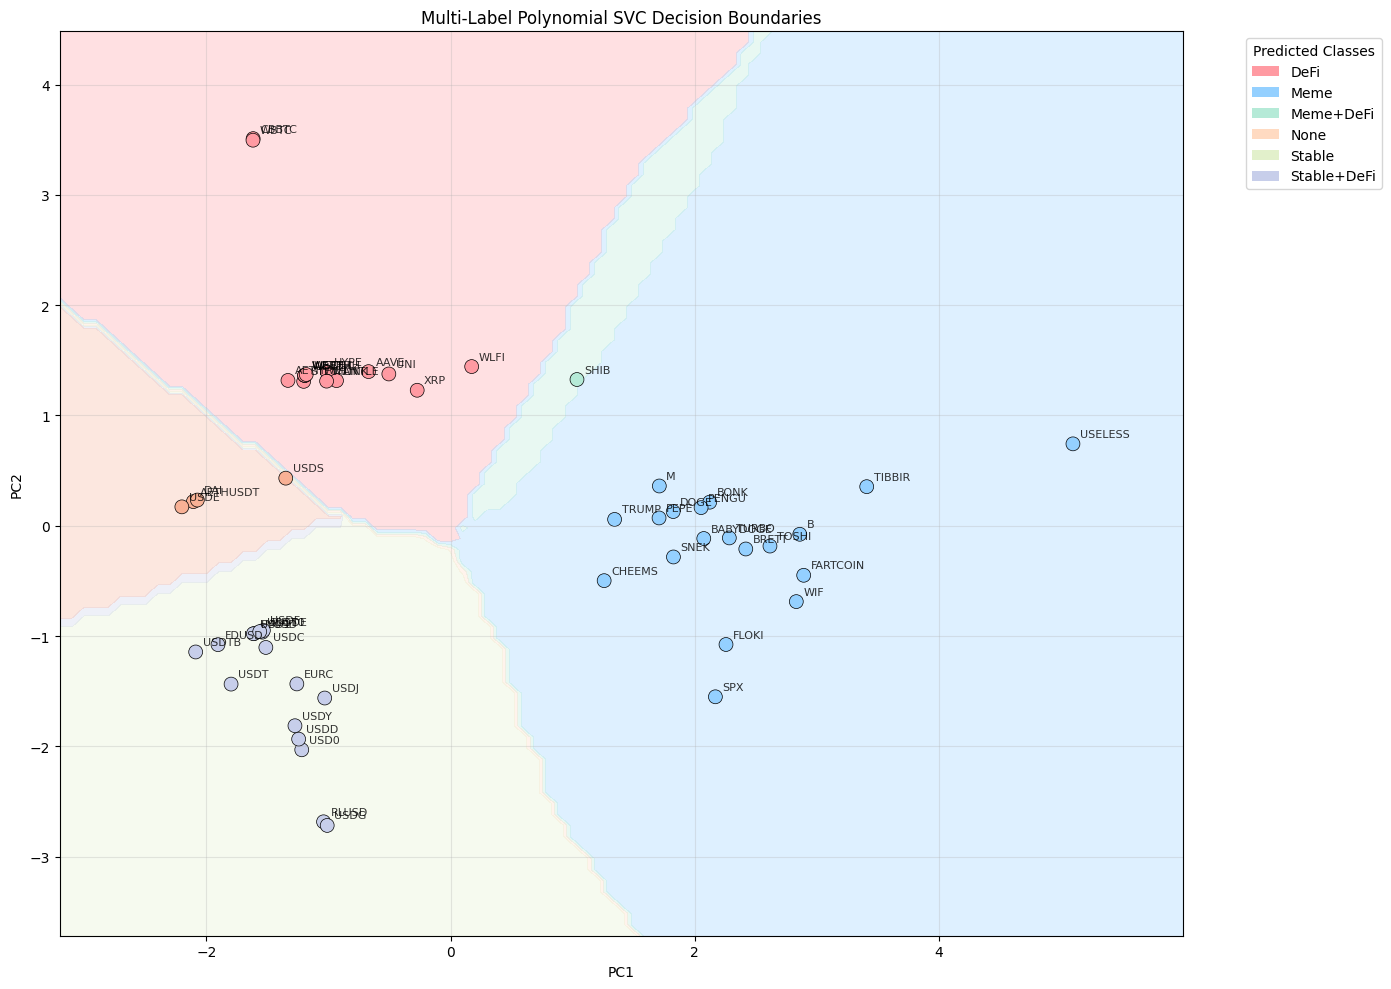

In [ ]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_knn.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Polynomial SVC Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
multi_label_svc_rbf = MultiOutputClassifier(SVC(C=10, kernel='rbf'))
multi_label_svc_rbf.fit(X_train, y_train)

,estimator,SVC(C=10)
,n_jobs,None
,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


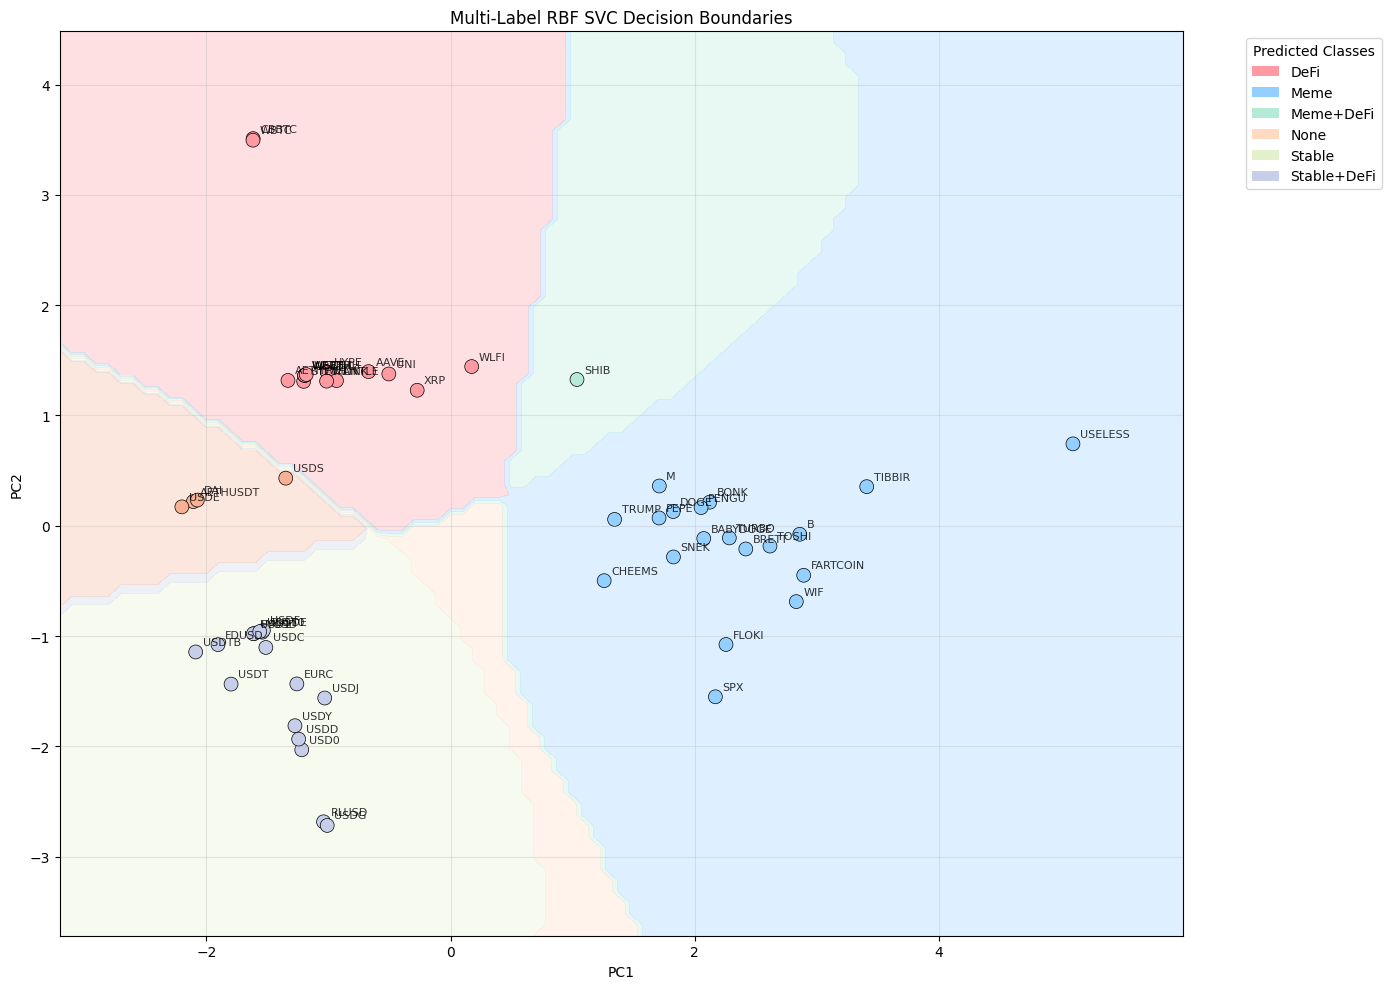

In [ ]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_svc_rbf.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label RBF SVC Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
multi_label_svc_sigmoid = MultiOutputClassifier(SVC(kernel='sigmoid'))
multi_label_svc_sigmoid.fit(X_train, y_train)

,estimator,SVC(kernel='sigmoid')
,n_jobs,None
,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


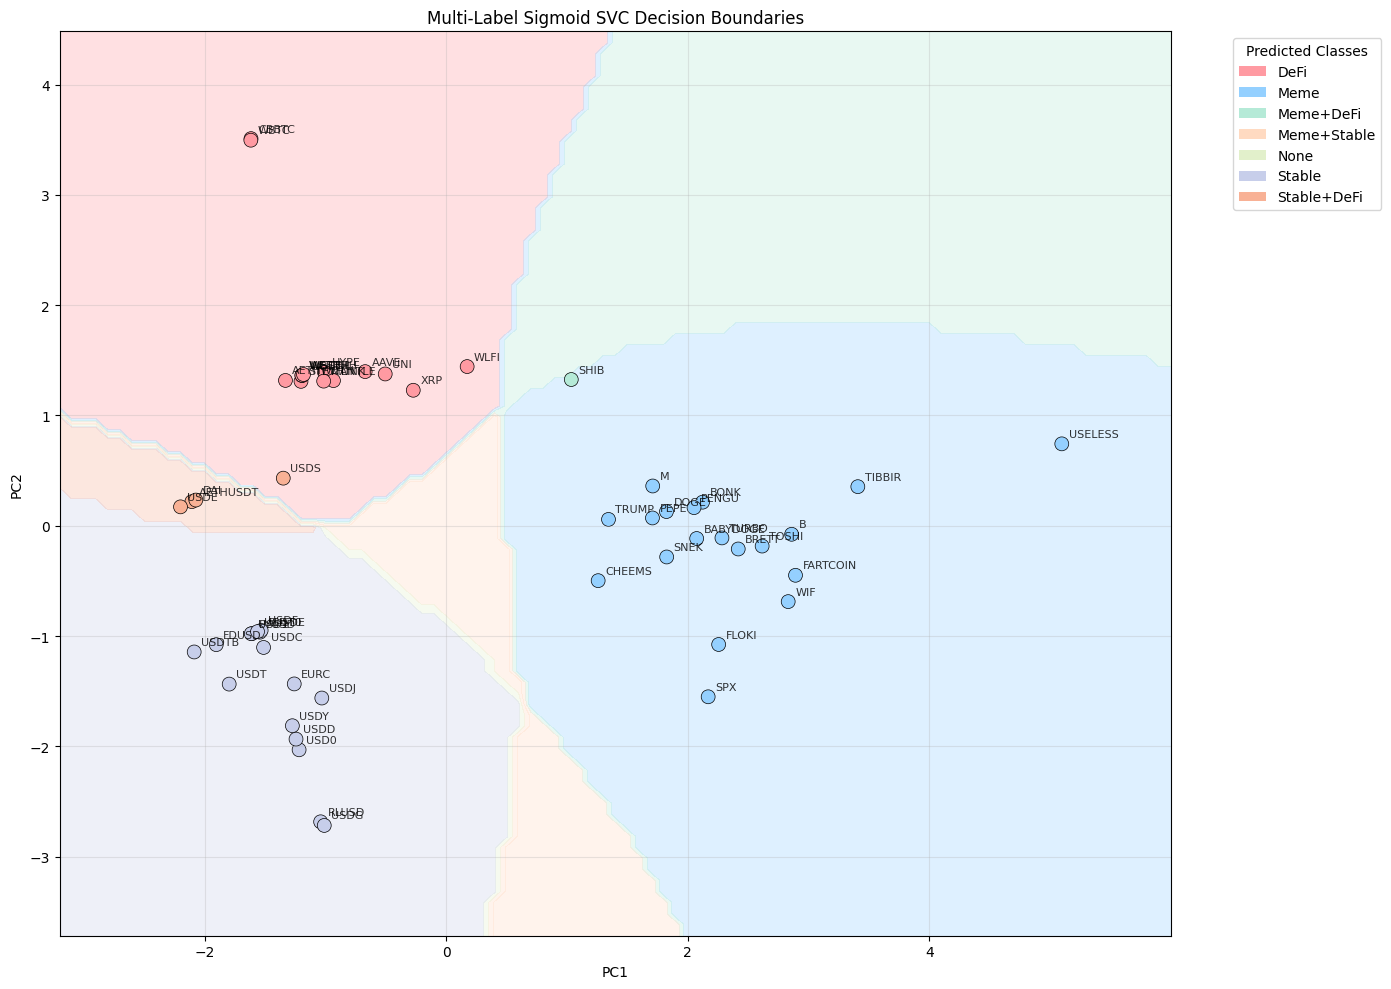

In [ ]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_svc_sigmoid.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Sigmoid SVC Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
multi_label_tree = MultiOutputClassifier(DecisionTreeClassifier())
multi_label_tree.fit(X_train, y_train)

,estimator,DecisionTreeClassifier()
,n_jobs,None
,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


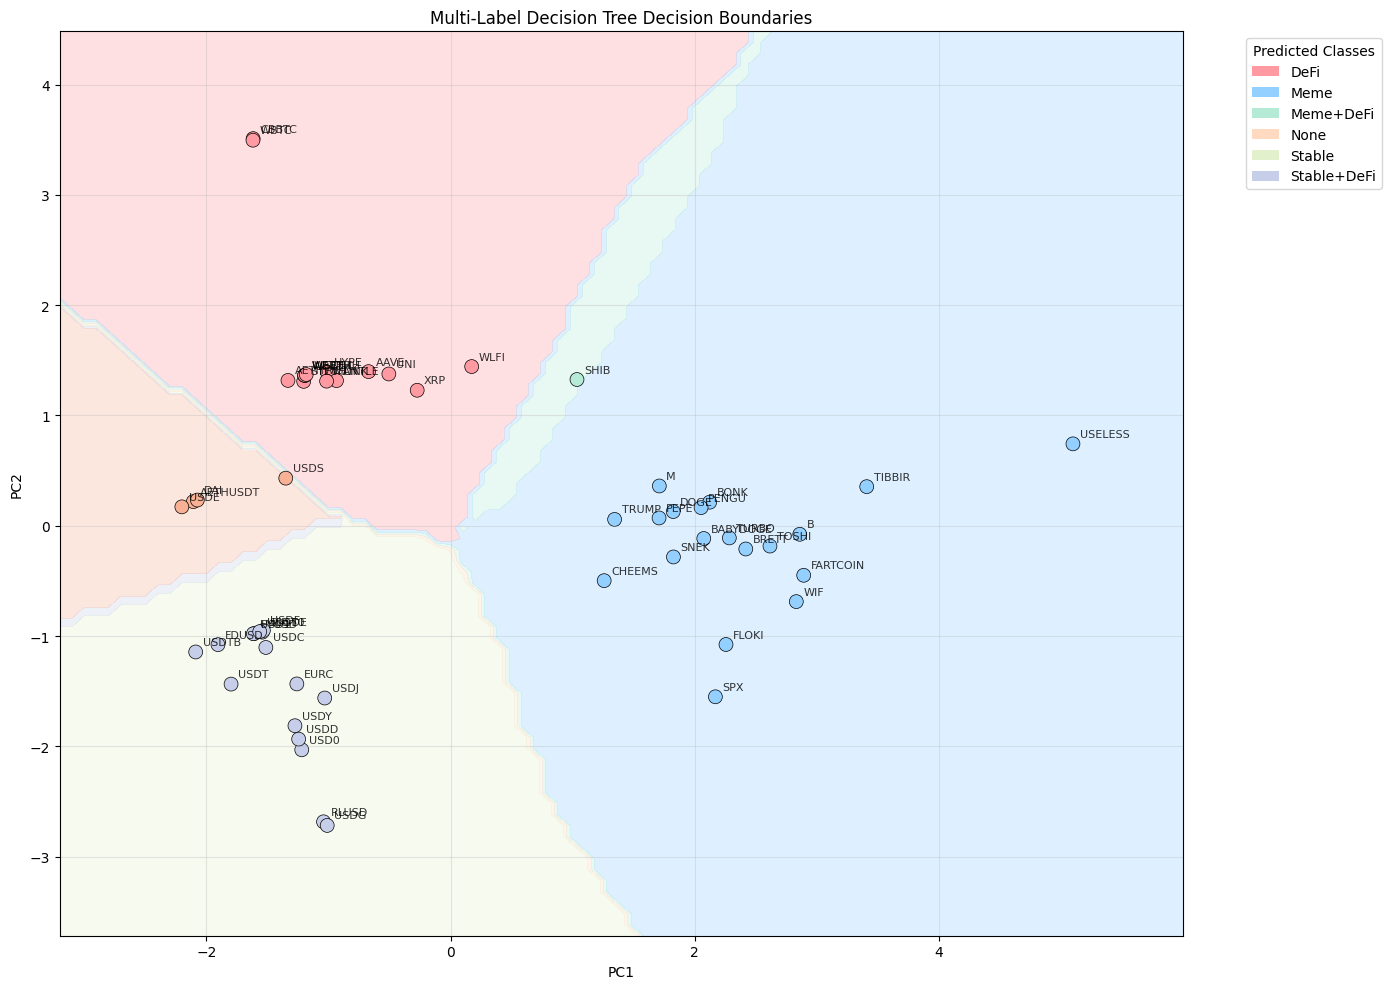

In [ ]:
plt.figure(figsize=(14, 10))

x_min, x_max = X['PC1'].min() - 1, X['PC1'].max() + 1
y_min, y_max = X['PC2'].min() - 1, X['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = multi_label_knn.predict(np.c_[xx.ravel(), yy.ravel()])

def get_combined_label(prediction):
    labels = []
    if prediction[0] == 1: labels.append('Meme')
    if prediction[1] == 1: labels.append('Stable')
    if prediction[2] == 1: labels.append('DeFi')
    return '+'.join(labels) if labels else 'None'

Z_labels = np.array([get_combined_label(z) for z in Z])

unique_labels = np.unique(Z_labels)
label_to_num = {label: i for i, label in enumerate(unique_labels)}
Z_numeric = np.array([label_to_num[label] for label in Z_labels])
Z_numeric = Z_numeric.reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap=cmap)

plot_df = X.copy()
plot_df['Class'] = y.apply(lambda row: get_combined_label([row['meme'], row['stable'], row['defi']]), axis=1)

scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], 
                      c=[label_to_num[label] for label in plot_df['Class']], 
                      cmap=cmap, s=100, edgecolors='black', linewidth=0.5)

for i, row in plot_df.iterrows():
    plt.annotate(df.loc[i, 'symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')
plt.title('Multi-Label Decision Tree Decision Boundaries')

legend_elements = [Patch(facecolor=colors[i], label=label) 
                   for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Predicted Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
trials = 10

logistic_regression_accuracy = 0
knn_accuracy = 0
nearest_centroid_accuracy = 0
svc_linear_accuracy = 0
svc_poly_accuracy = 0
svc_rbf_accuracy = 0
svc_sigmoid_accuracy = 0
tree_accuracy = 0

logistic_regression_y_pred = 0
knn_y_pred = 0
nearest_centroid_y_pred = 0
svc_linear_y_pred = 0
svc_poly_y_pred = 0
svc_rbf_y_pred = 0
svc_sigmoid_y_pred = 0
tree_y_pred = 0

accuracies = [
    logistic_regression_accuracy,
    knn_accuracy,
    nearest_centroid_accuracy,
    svc_linear_accuracy,
    svc_poly_accuracy,
    svc_rbf_accuracy,
    svc_sigmoid_accuracy,
    tree_accuracy
]

predictions = [
    logistic_regression_y_pred,
    knn_y_pred,
    nearest_centroid_y_pred,
    svc_linear_y_pred,
    svc_poly_y_pred,
    svc_rbf_y_pred,
    svc_sigmoid_y_pred,
    tree_y_pred
]

models = [
    multi_label_logistic_regression,
    multi_label_knn,
    multi_label_nearest_centroid,
    multi_label_svc_linear,
    multi_label_svc_poly,
    multi_label_svc_rbf,
    multi_label_svc_sigmoid,
    multi_label_tree
]

for i in range(trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    for i in range(len(models)):
        models[i].fit(X_train, y_train)
        predictions[i] = models[i].predict(X_test)
        accuracies[i] += accuracy_score(y_test, predictions[i], normalize=True)

for i in range(len(accuracies)):
    accuracies[i] *= (100 / trials)

In [ ]:
print(f"Accuracy of logistic regression: {accuracies[0]}%")
print(f"Accuracy of KNN: {accuracies[1]}%")
print(f"Accuracy of nearest centroid: {accuracies[2]}%")
print(f"Accuracy of linear SVC: {accuracies[3]}%")
print(f"Accuracy of polynomial SVC: {accuracies[4]}%")
print(f"Accuracy of RBF SVC: {accuracies[5]}%")
print(f"Accuracy of sigmoid SVC: {accuracies[6]}%")
print(f"Accuracy of decision trees: {accuracies[7]}%")

Accuracy of logistic regression: 97.85714285714286%
Accuracy of KNN: 97.14285714285715%
Accuracy of nearest centroid: 89.28571428571429%
Accuracy of linear SVC: 99.28571428571429%
Accuracy of polynomial SVC: 96.42857142857144%
Accuracy of RBF SVC: 98.57142857142858%
Accuracy of sigmoid SVC: 97.14285714285715%
Accuracy of decision trees: 91.42857142857142%


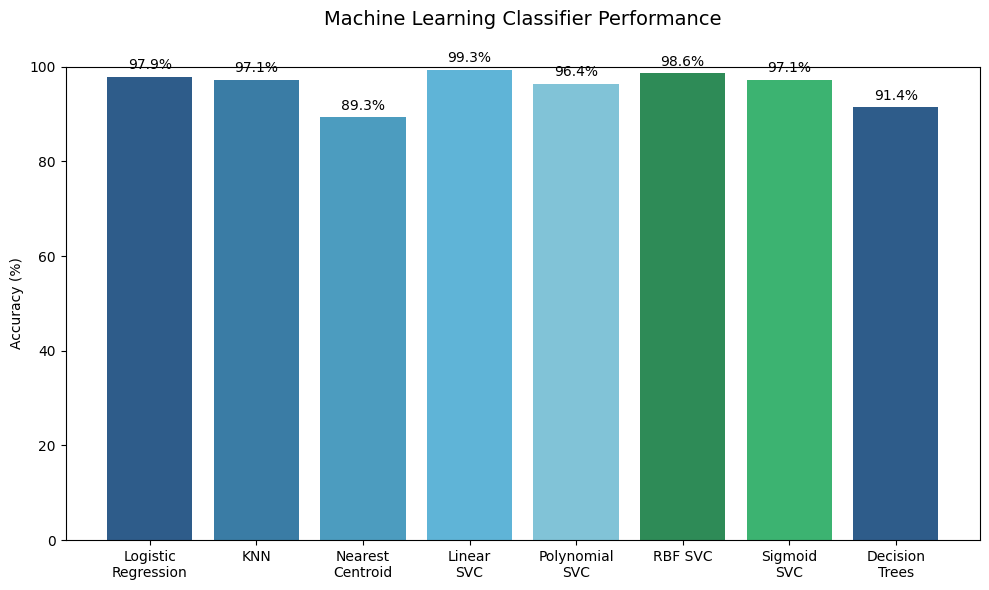

In [ ]:
classifiers = ['Logistic\nRegression', 'KNN', 'Nearest\nCentroid', 'Linear\nSVC', 'Polynomial\nSVC', 
               'RBF SVC', 'Sigmoid\nSVC', 'Decision\nTrees']

plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color = ['#2E5C8A', '#3A7CA5', '#4C9CBF', '#5FB4D7', '#81C3D7', 
                '#2E8B57', '#3CB371'])

plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Machine Learning Classifier Performance', pad=30, fontsize=14)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()